# Offset computation

We present here some code examples for computing accelerometer and gyroscope offsets using a data from a simple multi-point tumble test as presented in Fayat et al., 2021.

This notebook must be seen as an illustration of how such analysis can be performed to allow others to use the pipelines rather than code for replicating the exact panels of the paper.

## Imports and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import sys
sys.path.append("..")
from imu_helpers import IMU_Calibrator, get_immobility_smooth

# Color cycler for the figures with x, y, z curves
rgb = ["#D55E00", "#009E73", "#0072B2"]
rgb_cycler = cycler(color=rgb)

# Column names
col_acc = ["ax", "ay", "az"]
col_gyr = ["gx", "gy", "gz"]

# Load the data as a pandas dataframe
df = pd.read_csv("data/example_sensor_calibration.csv", index_col=0)

# Default parameter of IMU_Calibrator for selecting the time intervals
# used for the offset estimate
threshold = 5  # deg/s
sr = 300.  # herz

# Grab the accelerometer and gyroscope values
acc = df[col_acc].values # Accelerometer values, in G
gyr = df[col_gyr].values  # Gyroscope values, in deg/s

df.head(5)

,ax,ay,az,gx,gy,gz,time
0,0.017334,-0.082031,0.989258,2.197266,0.946045,-0.091553,0.000000
1,0.020264,-0.090332,0.989990,1.983643,0.915527,0.122070,0.003333
2,0.021729,-0.076172,0.984131,2.166748,1.037598,-0.213623,0.006667
3,0.016113,-0.090820,0.980225,2.014160,1.007080,-0.030518,0.010000
4,0.021240,-0.086670,0.980225,2.105713,0.976562,0.000000,0.013333


## Example data visualization

Text(0.5, 0.98, '')

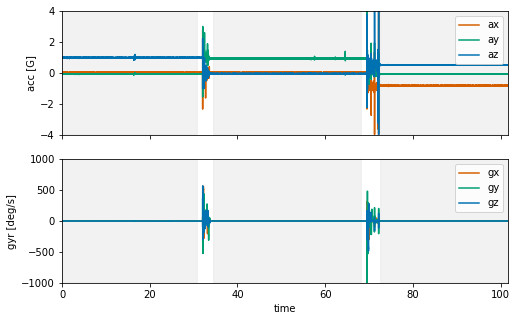

In [2]:
gyr_norm = np.linalg.norm(gyr, axis=1)
is_immobile = get_immobility_smooth(gyr_norm, threshold=threshold)


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
ax1.set_prop_cycle(rgb_cycler)
ax2.set_prop_cycle(rgb_cycler)

# Plot the acc and gyr data
df.plot(y=col_acc, x="time", ax=ax1, ylabel="acc [G]")
df.plot(y=col_gyr, x="time", ax=ax2, ylabel="gyr [deg/s]")

# Add the intervals below the threshold as a shaded area
# These time intervals will be used for the offset estimate
for ax, lim in zip([ax1, ax2], [4, 1000]):
    ax.fill_between(df.time, -lim, lim,
                    color="black", alpha=.05,
                    where=is_immobile)
    ax.set_ylim([-lim, lim])
ax1.set_xlim([df.time.iloc[0], df.time.iloc[-1]])
fig.suptitle("")

## Offset estimate

In [27]:
c = IMU_Calibrator(sr=sr, n_static_positions=3)
c.compute_offsets(acc, gyr)
print("acc offsets [G]:     ", c.acc_offsets)
print("gyr offsets [deg/s]: ", c.gyr_offsets)

acc offsets [G]:      [ 0.02793173 -0.07261109 -0.01655679]
gyr offsets [deg/s]:  [ 2.13623047  0.9765625  -0.09155273]
